In [3]:
cd ..

/home/modan9012/mmsegmentation


In [4]:
# Pytorch 설치 확인
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

import mmcv
print(mmcv.__version__)

# MMSegmentation 설치 확인
import mmseg
print(mmseg.__version__)

1.12.0+cu116 True
2.1.0
1.2.2


In [5]:
import os.path as osp
import numpy as np
from PIL import Image
import mmcv
import mmengine
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

In [7]:
png_file_count = sum(1 for filename in os.listdir(data_root+mask_dir) if filename.endswith('.png'))

print(png_file_count)

12233


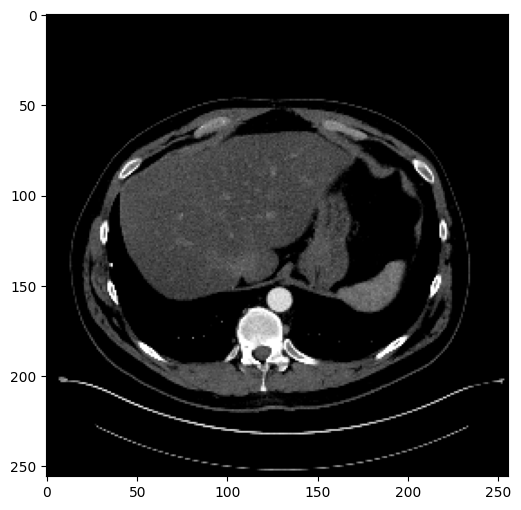

In [8]:
# 다운받은 데이터셋 확인
img = mmcv.imread(f'{data_root}/images/210_000.png')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [9]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset


@DATASETS.register_module()
class KiTS21Datasets(BaseSegDataset):
	# 클래스, 팔레트 정보에대한 딕셔너리 METAINFO 생성
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', **kwargs)

In [24]:
from mmengine import Config
cfg = Config.fromfile('segmenter_swin-t_mask_8xb1-160k_ade20k-512x512.py')
print(f'Config:\n{cfg.pretty_text}')

Config:
ann_dir = 'labels'
backbone_norm_cfg = dict(eps=1e-06, requires_grad=True, type='LN')
checkpoint = 'https://download.openmmlab.com/mmsegmentation/v0.5/pretrain/swin/swin_tiny_patch4_window7_224_20220317-1cdeb081.pth'
crop_size = (
    256,
    256,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        127.5,
        127.5,
        127.5,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        256,
        256,
    ),
    std=[
        127.5,
        127.5,
        127.5,
    ],
    type='SegDataPreProcessor')
data_root = '/home/modan9012/mmsegmentation/datasets/'
dataset_type = 'KiTS21Datasets'
default_hooks = dict(
    checkpoint=dict(by_epoch=True, interval=10, type='CheckpointHook'),
    early_stopping=dict(
        min_delta=0.001,
        monitor='val_loss',
        patience=10,
        type='EarlyStoppingHook'),
    logger=dict(interval=1, log_metric_by_epoch=True, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_see

#### **Test config 설정**

In [39]:
# dataset root와 이미지, annotation이 위치할 디렉토리 정의
data_root = './datasets/test-small/'
img_dir = 'images/'
mask_dir = 'masks/'
# 각 클래스에 대한 팔레트(색상)을 정의
classes = ('background', 'kidney')
palette = [[128,0,0],[0,128,0]]

In [40]:
cfg.norm_cfg = dict(type='LN', requires_grad=True)
cfg.crop_size = (256,256)
cfg.model.data_preprocessor.size = (256,256)
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.num_classes = 3
cfg.model.decode_head.out_channels= 3
cfg.model.decode_head.loss_decode=dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)
cfg.model.decode_head.threshold = 0.3



# 데이터셋 타입과 경로를 수정
cfg.dataset_type = 'KiTS21Datasets'
cfg.data_root = data_root


# test 파이프라인을 설정
cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(256, 256), keep_ratio=True),
    dict(type='PackSegInputs')
]

#test dataloader 설정
cfg.test_dataloader.dataset.type = cfg.dataset_type
cfg.test_dataloader.dataset.data_root = cfg.data_root
cfg.test_dataloader.dataset.data_prefix = dict(img_path=img_dir)
cfg.test_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.test_dataloader.dataset.ann_file = False

#test_evaluator 설정
cfg.test_evaluator = dict(
    format_only= True,
    keep_results=True,
    output_dir='./work_dirs/Swin-Seg/batch24lr0.01/format_results',
    iou_metrics=[
        'mIoU',
    ],
    type='IoUMetric')

# 사전학습된 모델 checkpoint 불러오기
cfg.load_from = './work_dirs/Swin-Seg/batch24lr0.01/epoch_300.pth'

#로그 디렉토리 설정
cfg.work_dir = './work_dirs/Swin-Seg/batch24lr0.01/'


#결과 재현을 위한 시드 값을 설정
cfg['randomness'] = dict(seed=0)

#최종 설정(config)을 출력
print(f'Config:\n{cfg.pretty_text}')

Config:
ann_dir = 'labels'
backbone_norm_cfg = dict(eps=1e-06, requires_grad=True, type='LN')
checkpoint = 'https://download.openmmlab.com/mmsegmentation/v0.5/pretrain/swin/swin_tiny_patch4_window7_224_20220317-1cdeb081.pth'
crop_size = (
    256,
    256,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        127.5,
        127.5,
        127.5,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        256,
        256,
    ),
    std=[
        127.5,
        127.5,
        127.5,
    ],
    type='SegDataPreProcessor')
data_root = './datasets/test-small/'
dataset_type = 'KiTS21Datasets'
default_hooks = dict(
    checkpoint=dict(by_epoch=True, interval=10, type='CheckpointHook'),
    early_stopping=dict(
        min_delta=0.001,
        monitor='val_loss',
        patience=10,
        type='EarlyStoppingHook'),
    logger=dict(interval=1, log_metric_by_epoch=True, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistS

In [41]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

06/10 01:14:13 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.19 | packaged by conda-forge | (default, Mar 20 2024, 12:47:35) [GCC 12.3.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 0
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: gcc (Debian 10.2.1-6) 10.2.1 20210110
    PyTorch: 1.12.0+cu116
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.6
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-

In [42]:
# 모델 학습 진행
runner.test()

06/10 01:14:15 - mmengine - DEBUG - Get class `TestLoop` from "loop" registry in "mmengine"
06/10 01:14:15 - mmengine - DEBUG - Get class `KiTS21Datasets` from "dataset" registry in "mmseg"
06/10 01:14:15 - mmengine - DEBUG - Get class `LoadImageFromFile` from "transform" registry in "mmengine"
06/10 01:14:15 - mmengine - DEBUG - An `LoadImageFromFile` instance is built from registry, and its implementation can be found in mmcv.transforms.loading
06/10 01:14:15 - mmengine - DEBUG - Get class `Resize` from "transform" registry in "mmseg"
06/10 01:14:15 - mmengine - DEBUG - An `Resize` instance is built from registry, and its implementation can be found in mmseg.datasets.transforms.transforms
06/10 01:14:15 - mmengine - DEBUG - Get class `PackSegInputs` from "transform" registry in "mmseg"
06/10 01:14:15 - mmengine - DEBUG - An `PackSegInputs` instance is built from registry, and its implementation can be found in mmseg.datasets.transforms.formatting
06/10 01:14:16 - mmengine - DEBUG - A

/home/modan9012/mmsegmentation/mmseg/datasets/transforms/loading.py:84: UserWarning: `reduce_zero_label` will be deprecated, if you would like to ignore the zero label, please set `reduce_zero_label=True` when dataset initialized
  warnings.warn('`reduce_zero_label` will be deprecated, '


06/10 01:14:17 - mmengine - INFO - Load checkpoint from ./work_dirs/Swin-Seg/batch24lr0.01/epoch_300.pth
06/10 01:14:17 - mmengine - INFO - Epoch(test) [    1/12233]    eta: 1:05:31  time: 0.3214  data_time: 0.1079  memory: 366  
06/10 01:14:17 - mmengine - INFO - Epoch(test) [    2/12233]    eta: 0:45:46  time: 0.2246  data_time: 0.1074  memory: 366  
06/10 01:14:18 - mmengine - INFO - Epoch(test) [    3/12233]    eta: 0:49:01  time: 0.2405  data_time: 0.1553  memory: 366  
06/10 01:14:18 - mmengine - INFO - Epoch(test) [    4/12233]    eta: 0:47:22  time: 0.2325  data_time: 0.1631  memory: 366  
06/10 01:14:18 - mmengine - INFO - Epoch(test) [    5/12233]    eta: 0:41:45  time: 0.2049  data_time: 0.1451  memory: 366  
06/10 01:14:18 - mmengine - INFO - Epoch(test) [    6/12233]    eta: 0:41:43  time: 0.2047  data_time: 0.1514  memory: 366  
06/10 01:14:18 - mmengine - INFO - Epoch(test) [    7/12233]    eta: 0:38:29  time: 0.1889  data_time: 0.1402  memory: 366  
06/10 01:14:18 - mme

{}

In [16]:
import shutil

# 압축할 폴더 경로
directory = '/home/modan9012/mmsegmentation/'

# 압축 파일의 경로 및 이름 (확장자 제외)
output_filename = '/home/modan9012/mmsegmentation-swin/'

# 폴더를 ZIP 파일로 압축
shutil.make_archive(output_filename, 'zip', directory)

print(f'{output_filename}.zip 파일이 생성되었습니다.')


/home/modan9012/mmsegmentation-swin/.zip 파일이 생성되었습니다.
